## About
This notebook generates Fig. SXXX, reporting on per-residue helicity predictions for all 32 sequences using pre-computed JPRED4 helicity predictions

## Dependencies
It requires `numpy`, `pandas`, `matplotlib`, and our FASTA sequence reading package [protfasta](https://github.com/holehouse-lab/protfasta)

## Data
The `synthetic_idrs.fasta` file was uploaed to [JPRED4](https://www.compbio.dundee.ac.uk/jpred/) which was run in batch mode. The resulting zip file was downloaded and then the per-residue helical probabilities extacted using the follwing `zsh` script to build single files with per-residue helical probabilities:


    # simple script to extract out helicity scores
    #!/bin/zsh
    
    for i in jp_*
    do
        cd $i
        cat ${i}.jnet | grep JNETPROPH | awk -F ":" {' print $2 '} > helicity_scores.csv
        cd ..
    done


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# installed as pip install protfasta
import protfasta

import os



In [2]:
def get_basal_fret(n):
    """
    Minifunction that takes in a sequence ID number and returns the basal mean EFRET

    Parameters
    -------------
    n : int
        Sequence ID

    Returns
    -------------
    float
        Returns the basal EFRET value for that sequence    
    """
    
    return DATA.loc[DATA['SequenceNumber'] == n, 'basal_mean'].iloc[0]

def get_NCPR(n):
    """
    Minifunction that takes in a sequence ID number and returns the NCPR for that sequence

    Parameters
    -------------
    n : int
        Sequence ID

    Returns
    -------------
    float
        Returns the NCPR for that sequence
    """
        
    return DATA.loc[DATA['SequenceNumber'] == n, 'NCPR'].iloc[0]



In [5]:
# read in the full data CSV using pandas
DATA = pd.read_csv('../summary_GOOSE_mergedInfo.csv')

# build sequence to basal FRET value mapping
seq2basal = {}
for i in range(1,33):    
    seq2basal[i] = get_basal_fret(i)

seq2basal = dict(sorted(seq2basal.items(), key=lambda item: item[1], reverse=True))

In [6]:
# parse JPRED helicity
jpred_rootdir = 'jpred/jp_batch_1697320300_all_seqs_v1_ALL_JOBS_ARCHIVE/'
filenames = os.listdir(jpred_rootdir)

seq2jpred = {}
# Iterate over each filename
for filename in filenames:

    # for each jpred batch directory
    if filename.find('jp_batch_') == 0:
        x = protfasta.read_fasta(f'{jpred_rootdir}/{filename}/{filename}.seq')
        name = int(list(x.keys())[0].split('_')[1])
        with open(f'{jpred_rootdir}/{filename}/helicity_scores.csv') as fh:
            context = fh.readlines()

        # list comprehension that takes a the first line from the file, removes the /nl at end, splits on commas, and
        # then for each element that is not empty sequentially converts into a float
        seq2jpred[name] = np.array([float(i) for i in context[0].strip().split(',') if i is not None and i != '' ])
        

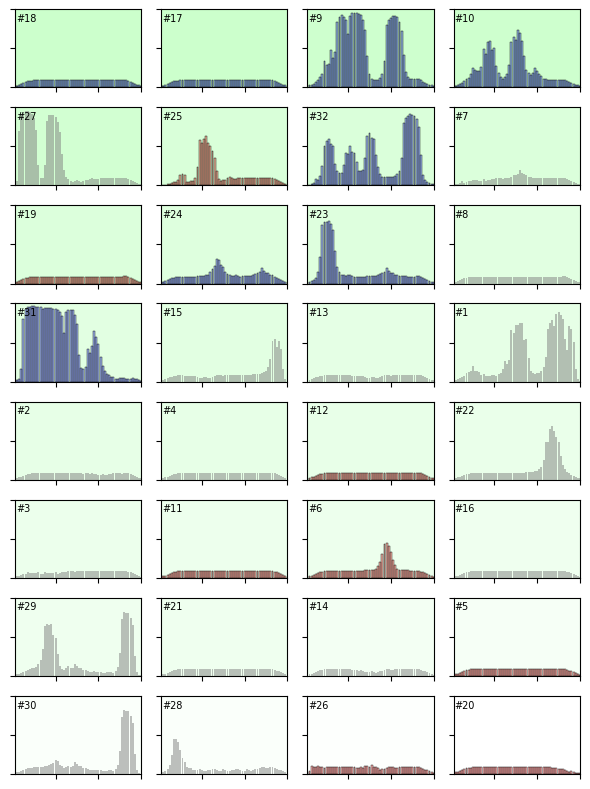

In [7]:

min_eFRET = min(list(seq2basal.values()))
max_eFRET = max(list(seq2basal.values()))

fig, axs = plt.subplots(8, 4, sharex=True, sharey=True, figsize=(6, 8))

global_idx = 0
residue_ix = np.arange(1,61)

average_helicity_jpred = {}

for i in range(8):
    for j in range(4):

        idx = list(seq2basal.keys())[global_idx]
        
        average_helicity_jpred[idx] = np.mean(seq2jpred[idx])
        
        alpha = (seq2basal[idx]-min_eFRET)/(max_eFRET-min_eFRET)*0.2
        axs[i, j].set_facecolor((0, 1, 0, alpha))

        NCPR = get_NCPR(idx)

        if NCPR > 0:        
            axs[i, j].bar(residue_ix, seq2jpred[idx], width=0.9, color=(0,0,1,abs(NCPR)), edgecolor='k',lw=0.3)
        elif NCPR < 0:
            axs[i, j].bar(residue_ix, seq2jpred[idx], width=0.9, color=(1,0,0,abs(NCPR)), edgecolor='k',lw=0.3)
        else:
            axs[i, j].bar(residue_ix, seq2jpred[idx], width=0.9, color='grey', alpha=0.5)
        
        axs[i, j].text(1.5, 0.85, f"#{idx}", fontsize=7)

        axs[i, j].set_xlim([1,60])
        axs[i, j].set_ylim([0,1])        
        
        global_idx = global_idx + 1

        # Hide tick labels for subplots that are not on the left-most or bottom
        if j != 0:  # not left-most
            axs[i, j].set_yticklabels([])    
        if i != 3:  # not bottom
            axs[i, j].set_xticklabels([])

plt.tight_layout()

plt.savefig('helicity_prediction_jpred.pdf')

In [8]:
with open('average_helicity_jpred.csv','w') as fh:
    for i in range(1,33):
        fh.write(f"{i}, {str(round(average_helicity_jpred[i],4))}\n")